In [1]:
# SPDX-FileCopyrightText: Copyright (c) 2024 NVIDIA CORPORATION & AFFILIATES.
# SPDX-FileCopyrightText: All rights reserved.
# SPDX-License-Identifier: Apache-2.0
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "1"
os.environ["EARTH2STUDIO_PACKAGE_TIMEOUT"] = "10000"
import subprocess as sp

os.makedirs("outputs", exist_ok=True)
output_file="./outputs/solar.nc"
from earth2studio.data import GFS, CDS, IFS
from earth2studio.io.netcdf4 import NetCDF4Backend
from earth2studio.models.auto import Package
from earth2studio.models.px import SFNO
from earth2studio.run import deterministic, diagnostic

from fcinterp.interp import ForecastInterpolation
from diagnostic.solarradiation_1h_afno import SolarRadiationAFNO
from collections import OrderedDict
from datetime import datetime
from math import ceil

import numpy as np
import torch
from tqdm import tqdm

from earth2studio.data import DataSource, fetch_data
from earth2studio.io import IOBackend
from earth2studio.models.dx import DiagnosticModel
from earth2studio.models.px import PrognosticModel
from earth2studio.perturbation import Perturbation
from earth2studio.utils.coords import CoordSystem, map_coords
from earth2studio.utils.time import to_time_array
from solarcorrdiff import scall_in_VARIABLES, SolarCorrdiffAll, scall_out_VARIABLES
import matplotlib.pyplot as plt
import copy
# Load the default model package which downloads the check point from NGC
forecast_package = SFNO.load_default_package()
forecast_model = SFNO.load_model(forecast_package)

# Load the interpolation model
interp_package_path = "./fcinterp"
prognostic_model = ForecastInterpolation.load_model(
        Package(interp_package_path, cache=False),
        fc_model=forecast_model,
)

# Load the diagnostic model for ssrd
diagnostic_package_path = "./diagnostic" 
diagnostic_model = SolarRadiationAFNO.load_model(
        Package(diagnostic_package_path, cache=False),
)


# Load the downscaling model for ssrd
solarcorrdiff_package_path = "./solarcorrdiff" 
solarcorrdiff_model = SolarCorrdiffAll.load_model(
        Package(solarcorrdiff_package_path, cache=False),
)

# Create the data source
data = GFS()

# Create the IO handler, store in memory
io = NetCDF4Backend(output_file)

timesteps = 24 * 7  # 10 mins per step
time= ["2025-07-21T18:00:00"]  # start time

def diagnostic_sr(
    time: list[str] | list[datetime] | list[np.datetime64],
    nsteps: int,
    prognostic: PrognosticModel,
    diagnostic: DiagnosticModel,
    solarcorrdiffic: SolarCorrdiffAll,
    data: DataSource,
    io: IOBackend,
    output_coords: CoordSystem = OrderedDict({}),
    device: torch.device | None = None,
) -> IOBackend:
    """Built in diagnostic workflow.
    This workflow creates a determinstic inference pipeline that couples a prognostic
    model with a diagnostic model.

    Parameters
    ----------
    time : list[str] | list[datetime] | list[np.datetime64]
        List of string, datetimes or np.datetime64
    nsteps : int
        Number of forecast steps
    prognostic : PrognosticModel
        Prognostic model
    diagnostic: DiagnosticModel
        Diagnostic model, must be on same coordinate axis as prognostic
    data : DataSource
        Data source
    io : IOBackend
        IO object
    output_coords: CoordSystem, optional
        IO output coordinate system override, by default OrderedDict({})
    device : torch.device, optional
        Device to run inference on, by default None

    Returns
    -------
    IOBackend
        Output IO object
    """
    # sphinx - diagnostic end
    print("Running diagnostic workflow!")
    # Load model onto the device
    device = (
        device
        if device is not None
        else torch.device("cuda" if torch.cuda.is_available() else "cpu")
    )
    print(f"Inference device: {device}")
    prognostic = prognostic.to(device)
    diagnostic = diagnostic.to(device)
    solarcorrdiffic = solarcorrdiffic.to(device)
    # Fetch data from data source and load onto device
    prognositc_ic = prognostic.input_coords()
    diagnostic_ic = diagnostic.input_coords()
    time = to_time_array(time)

    x, coords = fetch_data(
        source=data,
        time=time,
        variable=prognositc_ic["variable"],
        lead_time=prognositc_ic["lead_time"],
        device=device,
    )
    
    print(f"Fetched data from {data.__class__.__name__}")

    if output_coords:
        total_coords = output_coords
    else:
        total_coords = solarcorrdiffic.get_total_coord(time, nsteps)

    io.add_array(total_coords, "ssrd")

    # Map lat and lon if needed
    x, coords = map_coords(x, coords, prognositc_ic)
    
    # Create prognostic iterator
    model = prognostic.create_iterator(x, coords)

    print("Inference starting!")
    with tqdm(total=nsteps + 1, desc="Running inference") as pbar:
        for step, (x, coords) in enumerate(model):
            print("intime", time)
            print("protime", coords["time"])
            
            pro_out, pro_out_coord = copy.deepcopy(x), copy.deepcopy(coords) # record the output of pro model
            
            x, coords = map_coords(x, coords, diagnostic_ic)
            x, coords = diagnostic(x, coords)

            print("diatime", coords["time"])

            dia_out, dia_out_coord = copy.deepcopy(x), copy.deepcopy(coords)

            x, coords = solarcorrdiffic(pro_out, pro_out_coord, dia_out, dia_out_coord, True, step)
            
            if x is not None:
                x, coords = map_coords(x, coords, output_coords)
                coords.pop("variable")
                io.write(x, coords, "ssrd")

            pbar.update(1)
            if step == nsteps:
                break

    print("Inference complete")
    return io

def get_gpu_memory():
    command = "nvidia-smi --query-gpu=memory.free --format=csv"
    memory_free_info = sp.check_output(command.split()).decode('ascii').split('\n')[:-1][1:]
    memory_free_values = [int(x.split()[0]) for i, x in enumerate(memory_free_info)]
    return memory_free_values

# run inference
with torch.no_grad():
    diagnostic_sr(time, timesteps, prognostic_model, diagnostic_model, solarcorrdiff_model, data, io)

/root/miniconda3/envs/solar/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/root/miniconda3/envs/solar/lib/python3.10/site-packages/earth2studio/data/gfs.py:120: RuntimeWarning: coroutine 'GFS._async_init' was never awaited
  self.fs = None


2025-09-03 06:45:18.758 | WARNING  | earth2studio.models.auto.ngc:__init__:131 - Using NGC guest mode, which may fail due to unauthorized access. Consider using a valid NGC API key and org
Running diagnostic workflow!
Inference device: cuda


Fetching GFS data:   0%|          | 0/73 [00:00<?, ?it/s]

2025-09-03 06:45:54.786 | DEBUG    | earth2studio.data.gfs:fetch_array:380 - Fetching GFS grib file: noaa-gfs-bdp-pds/gfs.20250721/18/atmos/gfs.t18z.pgrb2.0p25.f000 145338958-640201
2025-09-03 06:45:54.790 | DEBUG    | earth2studio.data.gfs:fetch_array:380 - Fetching GFS grib file: noaa-gfs-bdp-pds/gfs.20250721/18/atmos/gfs.t18z.pgrb2.0p25.f000 280399144-919378
2025-09-03 06:45:54.792 | DEBUG    | earth2studio.data.gfs:fetch_array:380 - Fetching GFS grib file: noaa-gfs-bdp-pds/gfs.20250721/18/atmos/gfs.t18z.pgrb2.0p25.f000 357306753-1276441
2025-09-03 06:45:54.795 | DEBUG    | earth2studio.data.gfs:fetch_array:380 - Fetching GFS grib file: noaa-gfs-bdp-pds/gfs.20250721/18/atmos/gfs.t18z.pgrb2.0p25.f000 231850449-728215
2025-09-03 06:45:54.798 | DEBUG    | earth2studio.data.gfs:fetch_array:380 - Fetching GFS grib file: noaa-gfs-bdp-pds/gfs.20250721/18/atmos/gfs.t18z.pgrb2.0p25.f000 166519887-742251
2025-09-03 06:45:54.800 | DEBUG    | earth2studio.data.gfs:fetch_array:380 - Fetching GFS

Fetching GFS data: 100%|██████████| 73/73 [00:06<00:00, 10.91it/s]


Fetched data from GFS
Inference starting!


Running inference:   0%|          | 0/169 [00:00<?, ?it/s]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-21 18:00:00


Running inference:   1%|          | 1/169 [00:00<01:35,  1.76it/s]

diatime ['2025-07-21T18:00:00.000000000']
intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-21 19:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:   1%|          | 2/169 [00:16<26:55,  9.67s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-21 20:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:   2%|▏         | 3/169 [00:30<31:50, 11.51s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-21 21:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:   2%|▏         | 4/169 [00:44<34:02, 12.38s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-21 22:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:   3%|▎         | 5/169 [00:57<35:13, 12.89s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-21 23:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:   4%|▎         | 6/169 [01:11<35:50, 13.20s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-22 00:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:   4%|▍         | 7/169 [01:24<35:25, 13.12s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-22 01:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:   5%|▍         | 8/169 [01:38<36:03, 13.44s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-22 02:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:   5%|▌         | 9/169 [01:52<36:09, 13.56s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-22 03:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:   6%|▌         | 10/169 [02:06<36:14, 13.68s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-22 04:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:   7%|▋         | 11/169 [02:20<36:21, 13.81s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-22 05:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:   7%|▋         | 12/169 [02:34<36:11, 13.83s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-22 06:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:   8%|▊         | 13/169 [02:47<35:20, 13.59s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-22 07:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:   8%|▊         | 14/169 [03:01<35:34, 13.77s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-22 08:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:   9%|▉         | 15/169 [03:15<35:25, 13.80s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-22 09:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:   9%|▉         | 16/169 [03:29<35:14, 13.82s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-22 10:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  10%|█         | 17/169 [03:43<35:03, 13.84s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-22 11:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  11%|█         | 18/169 [03:57<34:48, 13.83s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-22 12:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  11%|█         | 19/169 [04:10<33:53, 13.56s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-22 13:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  12%|█▏        | 20/169 [04:24<33:59, 13.69s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-22 14:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  12%|█▏        | 21/169 [04:38<34:00, 13.79s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-22 15:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  13%|█▎        | 22/169 [04:51<33:42, 13.76s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-22 16:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  14%|█▎        | 23/169 [05:05<33:26, 13.75s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-22 17:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  14%|█▍        | 24/169 [05:19<33:12, 13.74s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-22 18:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  15%|█▍        | 25/169 [05:32<32:22, 13.49s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-22 19:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  15%|█▌        | 26/169 [05:46<32:31, 13.65s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-22 20:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  16%|█▌        | 27/169 [05:59<32:19, 13.66s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-22 21:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  17%|█▋        | 28/169 [06:13<32:06, 13.67s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-22 22:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  17%|█▋        | 29/169 [06:27<31:55, 13.68s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-22 23:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  18%|█▊        | 30/169 [06:40<31:46, 13.71s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-23 00:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  18%|█▊        | 31/169 [06:53<31:01, 13.49s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-23 01:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  19%|█▉        | 32/169 [07:08<31:14, 13.69s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-23 02:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  20%|█▉        | 33/169 [07:21<31:09, 13.74s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-23 03:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  20%|██        | 34/169 [07:36<31:18, 13.92s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-23 04:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  21%|██        | 35/169 [07:50<31:02, 13.90s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-23 05:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  21%|██▏       | 36/169 [08:04<30:48, 13.90s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-23 06:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  22%|██▏       | 37/169 [08:17<29:58, 13.62s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-23 07:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  22%|██▏       | 38/169 [08:31<30:06, 13.79s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-23 08:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  23%|██▎       | 39/169 [08:45<29:55, 13.81s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-23 09:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  24%|██▎       | 40/169 [08:58<29:43, 13.82s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-23 10:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  24%|██▍       | 41/169 [09:12<29:31, 13.84s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-23 11:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  25%|██▍       | 42/169 [09:26<29:17, 13.84s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-23 12:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  25%|██▌       | 43/169 [09:39<28:27, 13.55s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-23 13:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  26%|██▌       | 44/169 [09:53<28:29, 13.67s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-23 14:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  27%|██▋       | 45/169 [10:07<28:17, 13.69s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-23 15:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  27%|██▋       | 46/169 [10:20<28:02, 13.68s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-23 16:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  28%|██▊       | 47/169 [10:34<27:50, 13.70s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-23 17:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  28%|██▊       | 48/169 [10:48<27:36, 13.69s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-23 18:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  29%|██▉       | 49/169 [11:01<26:51, 13.43s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-23 19:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  30%|██▉       | 50/169 [11:15<27:22, 13.80s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-23 20:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  30%|███       | 51/169 [11:29<27:05, 13.77s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-23 21:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  31%|███       | 52/169 [11:43<26:48, 13.75s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-23 22:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  31%|███▏      | 53/169 [11:56<26:37, 13.77s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-23 23:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  32%|███▏      | 54/169 [12:10<26:25, 13.79s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-24 00:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  33%|███▎      | 55/169 [12:23<25:49, 13.59s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-24 01:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  33%|███▎      | 56/169 [12:38<25:56, 13.78s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-24 02:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  34%|███▎      | 57/169 [12:52<25:49, 13.84s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-24 03:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  34%|███▍      | 58/169 [13:06<25:39, 13.87s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-24 04:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  35%|███▍      | 59/169 [13:19<25:28, 13.89s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-24 05:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  36%|███▌      | 60/169 [13:33<25:15, 13.90s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-24 06:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  36%|███▌      | 61/169 [13:46<24:32, 13.64s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-24 07:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  37%|███▋      | 62/169 [14:01<24:38, 13.81s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-24 08:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  37%|███▋      | 63/169 [14:15<24:26, 13.83s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-24 09:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  38%|███▊      | 64/169 [14:28<24:12, 13.83s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-24 10:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  38%|███▊      | 65/169 [14:42<23:57, 13.82s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-24 11:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  39%|███▉      | 66/169 [14:56<23:45, 13.84s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-24 12:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  40%|███▉      | 67/169 [15:09<23:02, 13.56s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-24 13:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  40%|████      | 68/169 [15:23<23:02, 13.69s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-24 14:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  41%|████      | 69/169 [15:37<22:47, 13.68s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-24 15:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  41%|████▏     | 70/169 [15:51<23:01, 13.96s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-24 16:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  42%|████▏     | 71/169 [16:05<22:41, 13.90s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-24 17:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  43%|████▎     | 72/169 [16:19<22:21, 13.83s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-24 18:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  43%|████▎     | 73/169 [16:32<21:43, 13.58s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-24 19:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  44%|████▍     | 74/169 [16:46<21:41, 13.70s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-24 20:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  44%|████▍     | 75/169 [16:59<21:29, 13.72s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-24 21:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  45%|████▍     | 76/169 [17:13<21:14, 13.71s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-24 22:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  46%|████▌     | 77/169 [17:27<21:02, 13.72s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-24 23:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  46%|████▌     | 78/169 [17:41<20:49, 13.73s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-25 00:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  47%|████▋     | 79/169 [17:54<20:14, 13.50s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-25 01:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  47%|████▋     | 80/169 [18:08<20:18, 13.69s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-25 02:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  48%|████▊     | 81/169 [18:22<20:11, 13.77s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-25 03:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  49%|████▊     | 82/169 [18:36<20:03, 13.83s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-25 04:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  49%|████▉     | 83/169 [18:49<19:50, 13.85s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-25 05:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  50%|████▉     | 84/169 [19:03<19:37, 13.86s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-25 06:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  50%|█████     | 85/169 [19:16<19:02, 13.60s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-25 07:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  51%|█████     | 86/169 [19:31<19:04, 13.79s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-25 08:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  51%|█████▏    | 87/169 [19:44<18:53, 13.82s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-25 09:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  52%|█████▏    | 88/169 [19:58<18:40, 13.84s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-25 10:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  53%|█████▎    | 89/169 [20:12<18:27, 13.84s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-25 11:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  53%|█████▎    | 90/169 [20:26<18:13, 13.84s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-25 12:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  54%|█████▍    | 91/169 [20:39<17:37, 13.55s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-25 13:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  54%|█████▍    | 92/169 [20:53<17:34, 13.69s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-25 14:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  55%|█████▌    | 93/169 [21:07<17:20, 13.70s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-25 15:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  56%|█████▌    | 94/169 [21:20<17:06, 13.69s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-25 16:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  56%|█████▌    | 95/169 [21:35<17:16, 14.01s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-25 17:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  57%|█████▋    | 96/169 [21:49<16:56, 13.92s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-25 18:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  57%|█████▋    | 97/169 [22:02<16:31, 13.77s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-25 19:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  58%|█████▊    | 98/169 [22:16<16:22, 13.83s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-25 20:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  59%|█████▊    | 99/169 [22:30<16:04, 13.79s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-25 21:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  59%|█████▉    | 100/169 [22:44<15:48, 13.75s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-25 22:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  60%|█████▉    | 101/169 [22:57<15:35, 13.76s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-25 23:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  60%|██████    | 102/169 [23:11<15:26, 13.82s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-26 00:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  61%|██████    | 103/169 [23:24<14:56, 13.59s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-26 01:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  62%|██████▏   | 104/169 [23:39<14:58, 13.82s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-26 02:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  62%|██████▏   | 105/169 [23:53<14:46, 13.85s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-26 03:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  63%|██████▎   | 106/169 [24:07<14:34, 13.88s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-26 04:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  63%|██████▎   | 107/169 [24:20<14:20, 13.89s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-26 05:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  64%|██████▍   | 108/169 [24:34<14:08, 13.91s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-26 06:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  64%|██████▍   | 109/169 [24:47<13:38, 13.64s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-26 07:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  65%|██████▌   | 110/169 [25:02<13:33, 13.80s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-26 08:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  66%|██████▌   | 111/169 [25:15<13:22, 13.83s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-26 09:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  66%|██████▋   | 112/169 [25:29<13:09, 13.85s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-26 10:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  67%|██████▋   | 113/169 [25:43<12:58, 13.90s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-26 11:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  67%|██████▋   | 114/169 [25:57<12:43, 13.87s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-26 12:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  68%|██████▊   | 115/169 [26:10<12:13, 13.58s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-26 13:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  69%|██████▊   | 116/169 [26:24<12:06, 13.70s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-26 14:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  69%|██████▉   | 117/169 [26:38<11:52, 13.70s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-26 15:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  70%|██████▉   | 118/169 [26:51<11:38, 13.70s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-26 16:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  70%|███████   | 119/169 [27:05<11:25, 13.71s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-26 17:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  71%|███████   | 120/169 [27:19<11:13, 13.74s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-26 18:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  72%|███████▏  | 121/169 [27:32<10:46, 13.47s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-26 19:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  72%|███████▏  | 122/169 [27:46<10:40, 13.64s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-26 20:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  73%|███████▎  | 123/169 [28:00<10:28, 13.66s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-26 21:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  73%|███████▎  | 124/169 [28:13<10:15, 13.68s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-26 22:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  74%|███████▍  | 125/169 [28:27<10:02, 13.70s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-26 23:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  75%|███████▍  | 126/169 [28:42<10:08, 14.14s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-27 00:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  75%|███████▌  | 127/169 [28:55<09:39, 13.80s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-27 01:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  76%|███████▌  | 128/169 [29:09<09:29, 13.90s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-27 02:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  76%|███████▋  | 129/169 [29:23<09:16, 13.92s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-27 03:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  77%|███████▋  | 130/169 [29:37<09:02, 13.92s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-27 04:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  78%|███████▊  | 131/169 [29:51<08:51, 13.98s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-27 05:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  78%|███████▊  | 132/169 [30:05<08:36, 13.97s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-27 06:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  79%|███████▊  | 133/169 [30:19<08:14, 13.73s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-27 07:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  79%|███████▉  | 134/169 [30:33<08:05, 13.86s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-27 08:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  80%|███████▉  | 135/169 [30:47<07:51, 13.88s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-27 09:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  80%|████████  | 136/169 [31:01<07:38, 13.89s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-27 10:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  81%|████████  | 137/169 [31:14<07:24, 13.88s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-27 11:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  82%|████████▏ | 138/169 [31:28<07:10, 13.88s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-27 12:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  82%|████████▏ | 139/169 [31:41<06:47, 13.58s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-27 13:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  83%|████████▎ | 140/169 [31:55<06:37, 13.70s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-27 14:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  83%|████████▎ | 141/169 [32:09<06:23, 13.69s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-27 15:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  84%|████████▍ | 142/169 [32:23<06:15, 13.89s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-27 16:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  85%|████████▍ | 143/169 [32:37<05:59, 13.83s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-27 17:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  85%|████████▌ | 144/169 [32:51<05:45, 13.81s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-27 18:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  86%|████████▌ | 145/169 [33:03<05:24, 13.53s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-27 19:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  86%|████████▋ | 146/169 [33:18<05:14, 13.69s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-27 20:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  87%|████████▋ | 147/169 [33:31<05:01, 13.69s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-27 21:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  88%|████████▊ | 148/169 [33:45<04:47, 13.68s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-27 22:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  88%|████████▊ | 149/169 [33:59<04:34, 13.72s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-27 23:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  89%|████████▉ | 150/169 [34:12<04:21, 13.74s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-28 00:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  89%|████████▉ | 151/169 [34:26<04:03, 13.53s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-28 01:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  90%|████████▉ | 152/169 [34:40<03:53, 13.71s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-28 02:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  91%|█████████ | 153/169 [34:54<03:40, 13.76s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-28 03:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  91%|█████████ | 154/169 [35:07<03:26, 13.80s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-28 04:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  92%|█████████▏| 155/169 [35:21<03:13, 13.85s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-28 05:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  92%|█████████▏| 156/169 [35:35<03:00, 13.86s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-28 06:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  93%|█████████▎| 157/169 [35:48<02:43, 13.60s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-28 07:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  93%|█████████▎| 158/169 [36:02<02:31, 13.79s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-28 08:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  94%|█████████▍| 159/169 [36:16<02:18, 13.82s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-28 09:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  95%|█████████▍| 160/169 [36:30<02:04, 13.84s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-28 10:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  95%|█████████▌| 161/169 [36:44<01:50, 13.86s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-28 11:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  96%|█████████▌| 162/169 [36:58<01:36, 13.85s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-28 12:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  96%|█████████▋| 163/169 [37:11<01:21, 13.58s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-28 13:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  97%|█████████▋| 164/169 [37:25<01:08, 13.75s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-28 14:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  98%|█████████▊| 165/169 [37:40<00:56, 14.17s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-28 15:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  98%|█████████▊| 166/169 [37:54<00:42, 14.05s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-28 16:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  99%|█████████▉| 167/169 [38:08<00:27, 13.97s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-28 17:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference:  99%|█████████▉| 168/169 [38:22<00:13, 13.90s/it]

intime ['2025-07-21T18:00:00.000000000']
protime ['2025-07-21T18:00:00.000000000']
2025-07-28 18:00:00
diatime ['2025-07-21T18:00:00.000000000']



Running inference: 100%|██████████| 169/169 [38:35<00:00, 13.70s/it]

Inference complete


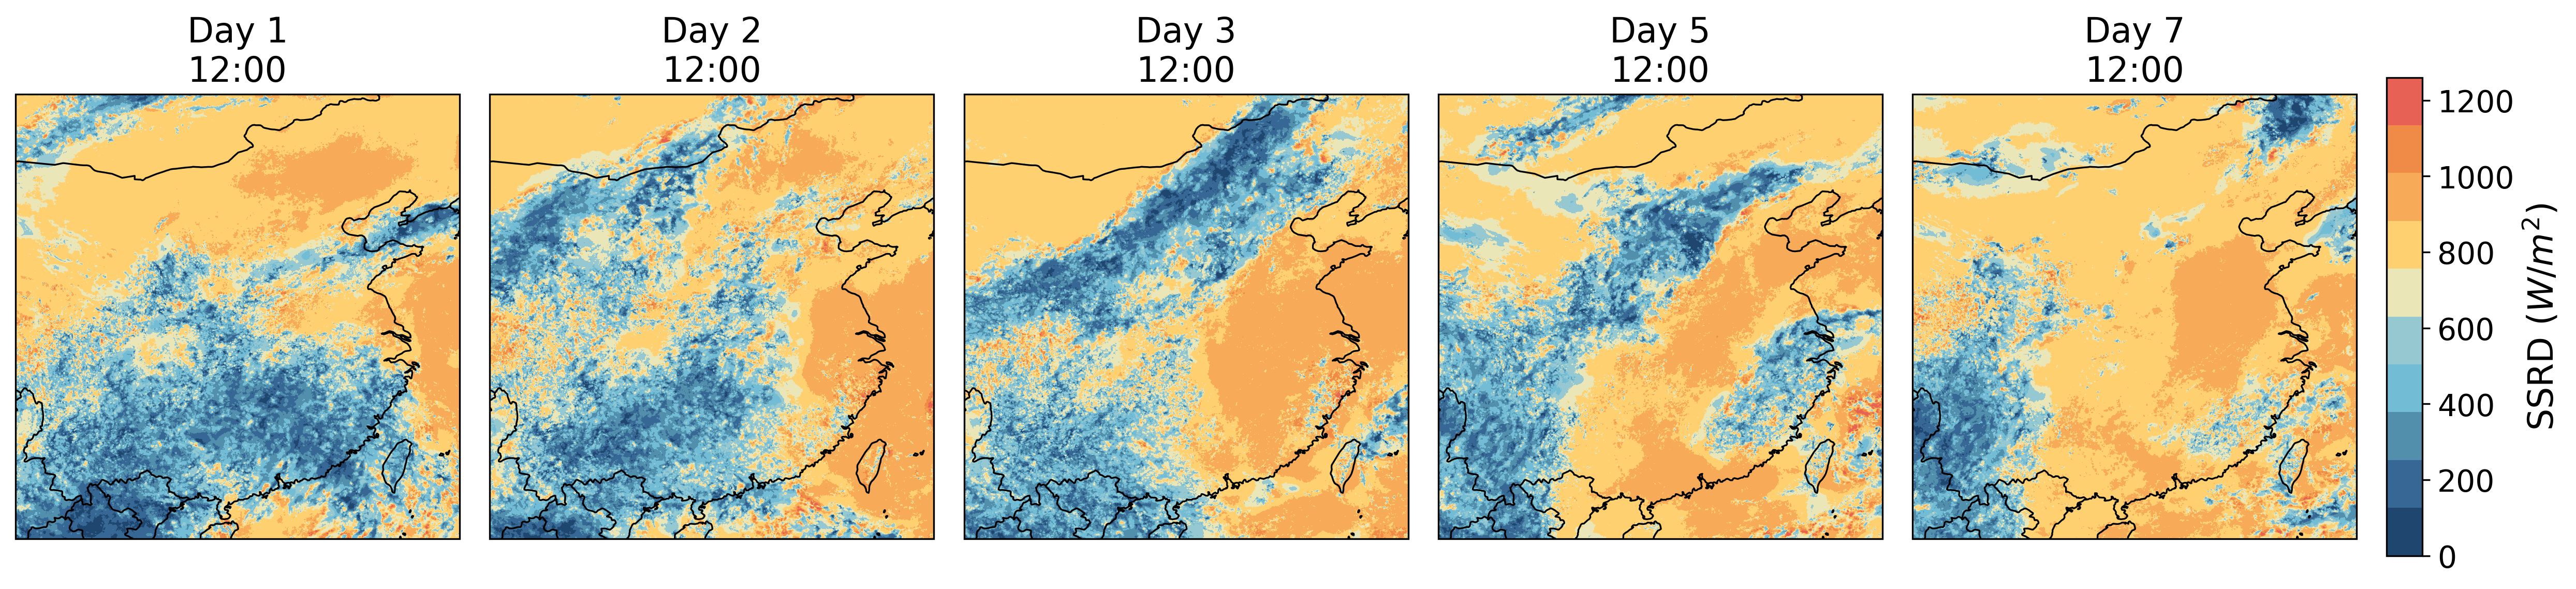

Plotting complete


In [2]:
import os
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import datetime
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
from matplotlib.colors import ListedColormap
import pandas as pd

color_list = ['#1e466e', '#376795', '#528fad', '#72bcd5', '#96c8d2', '#ebe6b7', '#ffd06f', '#f7aa58', '#ef8a47', '#e76254']
custom_cmap = ListedColormap(color_list)

pred_nc_path = './outputs/solar.nc'

lead_time_index = [54, 198, 342, 630, 918]
# Load prediction
with xr.open_dataset(pred_nc_path) as ds:
    stacked_daily_pred = ds['ssrd'].isel(time=0, lead_time=lead_time_index).values
    lons = ds['lon']
    lats = ds['lat']

# output_dir = "./output"
# os.makedirs(output_dir, exist_ok=True)


vmin_ssrd = stacked_daily_pred.min()
vmax_ssrd = stacked_daily_pred.max()

norm_ssrd = mpl.colors.Normalize(vmin=vmin_ssrd, vmax=vmax_ssrd)

# --- Plotting Configuration ---
n_col = 6
fig = plt.figure(figsize=(20, 4), dpi=300)

# Adjust width ratios for 7 columns: cbar1, pred1, gt1, pred2, gt2, error, cbar2
gs = GridSpec(1, n_col, figure=fig, width_ratios=[1, 1, 1, 1, 1, 0.08],
              height_ratios=[1], hspace=0.08, wspace=0.08)

current_day = [1, 2, 3, 5, 7]
# --- Plotting loop ---
for i_col in range(n_col):

    if i_col < n_col - 1:
        ax = fig.add_subplot(gs[0, i_col], projection=ccrs.PlateCarree())

        data = stacked_daily_pred[i_col]
        contour = ax.contourf(lons, lats, data, levels=100, cmap=custom_cmap, transform=ccrs.PlateCarree(), norm=norm_ssrd)
        
        ax.set_title(f"Day {current_day[i_col]}\n12:00", fontsize=16)
        # Common plot features
        ax.add_feature(cfeature.BORDERS, linewidth=0.8, edgecolor='black')
        ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
        ax.set_extent([lons.min(), lons.max(), lats.min(), lats.max()], crs=ccrs.PlateCarree())
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_xticks([])
        ax.set_yticks([])

    else:

        cbar_ax = fig.add_subplot(gs[:, i_col])
        sm_ssrd = plt.cm.ScalarMappable(cmap=custom_cmap, norm=norm_ssrd)
        cbar = fig.colorbar(sm_ssrd, cax=cbar_ax, orientation='vertical')
        cbar.set_label('SSRD ($W/m^2$)', fontsize=16)
        cbar_ax.tick_params(labelsize=14)

plt.tight_layout()
plt.show()
print("Plotting complete")